# Practical adaptive quantum tomography: Data Analysis #
Christopher Granade, Christopher Ferrie, Steven Flammia<br>
University of Sydney

<hr>
#### Abstract ####
This notebook analyzes the performance data for self-guided tomography hybridized with Bayesian and frequentist methods. This data was generated using high-performance computing (HPC) resources, and comprises running the self-guided algorithm approximately 500,000 times under a wide variety of conditions.
<hr>

# Setup #

We begin by configuring division for Python 2 backwards-compatibility, then configuring Jupyter Notebook and Matplotlib to output high-resolution inline figures.

In [1]:
from __future__ import division
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100}

We then import our postprocessing module, which provides a number of useful functions for loading, sorting, filtering and plotting data.

In [2]:
from postproc import *

Having done so, we can now load the data itself.

In [3]:
data = load_data('packed_data.hdf5')
print("Loaded {} trials.".format(data.shape[0]))

Loaded 554250 trials.


The data consists of *rows*, each of which describes a single trial. The *columns* then specify data about that trial, such as the dimension of the quantum states used, the loss for each hybridizing method and according to each loss function, and the Git hash of the Python package used to generate the data.

In [4]:
data.columns

Index([u'completed_at', u'cond_number', u'dim', u'distinguishability_lsf',
       u'distinguishability_smc', u'distinguishability_spsa',
       u'distinguishability_wlsf', u'gain_offset', u'gain_pow', u'gain_scale',
       u'git_hash', u'hostname', u'infidelity_lsf', u'infidelity_smc',
       u'infidelity_spsa', u'infidelity_wlsf', u'lsf_min_eig', u't_elap_lsf',
       u'min_n_ess', u'n_iters', u'n_particles', u'n_shots', u'n_subsystems',
       u'prior_rank', u'quad_loss_lsf', u'quad_loss_smc', u'quad_loss_spsa',
       u'quad_loss_wlsf', u'resample_a', u'resample_count', u'shuffle',
       u't_elap_smc', u't_elap_spsa', u'step_pow', u'step_scale',
       u'true_prior_rank', u'true_purity', u'wcond_number', u'wlsf_min_eig',
       u't_elap_wlsf'],
      dtype='object')

Having loaded the data, we can then filter by particular properties of the trials that we are interested in, using Pandas' ``DataFrame.pipe`` method to combine this filtering with plotting functions. For instance, we can note that the particle filters used to hybridize qubit state tomography employ a number of resampling steps that goes roughly as the square root of the amount of data collected.

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


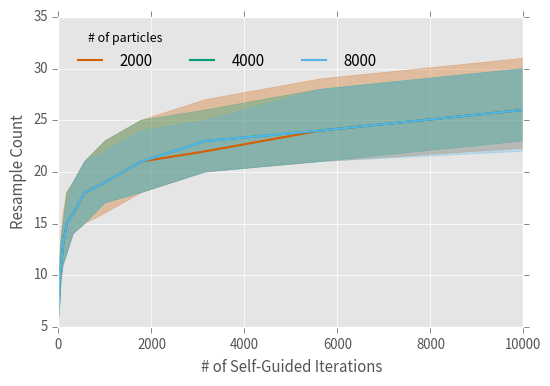

In [5]:
for n_particles in [2000, 4000, 8000]:
    data.pipe(select,
        dim=2, shuffle=False, n_shots=500, n_particles=n_particles,
        n_subsystems=1
    ).pipe(plot_quantile_errorfill,
        x_col='n_iters', y_col='resample_count',
        label='{}'.format(n_particles)
    )
plt.xlabel('# of Self-Guided Iterations')
plt.ylabel('Resample Count')
leg = plt.legend(ncol=3, title='# of particles', loc='upper left')
leg.get_title().set_position((-100, 0)) # http://stackoverflow.com/a/15638737

## Self-Guided Tomography and Purity ##

As noted in the main paper, the self-guided tomography algorithm assumes that the true state is pure. Here, we confirm that and show that self-guided tomography fails for mixed states. Importantly, self-guided tomography still captures some important features of the true state, however, as we confirm by comparing to the best distinguishability that can be achived under the assumption of a pure state.

In [6]:
purities = data.pipe(select,
    n_shots=500, dim=2, n_iters=10000, true_prior_rank=2
)['true_purity'].copy()
purities.sort_values(inplace=True)
purities = purities.get_values()
min_distinguishability = (1 - np.sqrt(2 * purities - 1)) / 2

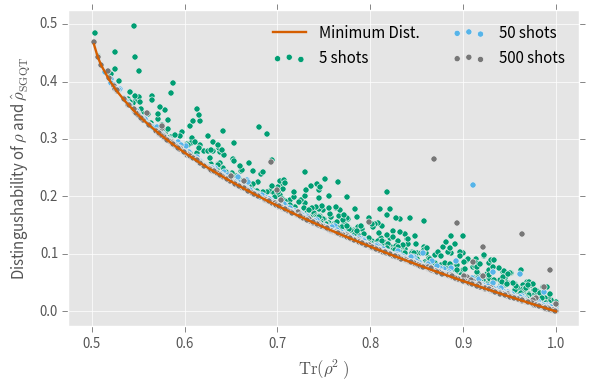

In [7]:
ax = plt.plot(purities, min_distinguishability, plt.rcParams['axes.color_cycle'][0], label='Minimum Dist.', lw=1.7, zorder=100, linestyle='-')

for idx_color, n_shots in enumerate([5, 50, 500]):
    data.pipe(select,
        n_shots=n_shots, dim=2, n_iters=10000, true_prior_rank=2
    ).plot(kind='scatter', ax=plt.gca(),
        x='true_purity', y='distinguishability_spsa',
        color=plt.rcParams['axes.color_cycle'][1 + idx_color],
        label='{} shots'.format(n_shots)
    )

plt.legend(numpoints=1, ncol=2)
plt.xlim(xmin=0.475, xmax=1.025)
plt.ylim(ymin=-0.025, ymax=0.525)
plt.xlabel(r'$\operatorname{Tr}(\rho^2)$')
plt.ylabel(r'Distingushability of $\rho$ and $\hat{\rho}_{\mathrm{SGQT}}$')
savefig('min-distinguishability')

## Qubits ##
### Pure ###

For pure states of a qubit, all methods work fairly well as measured by the infidelity loss function, and continue to do so across a range of different numbers of shots.

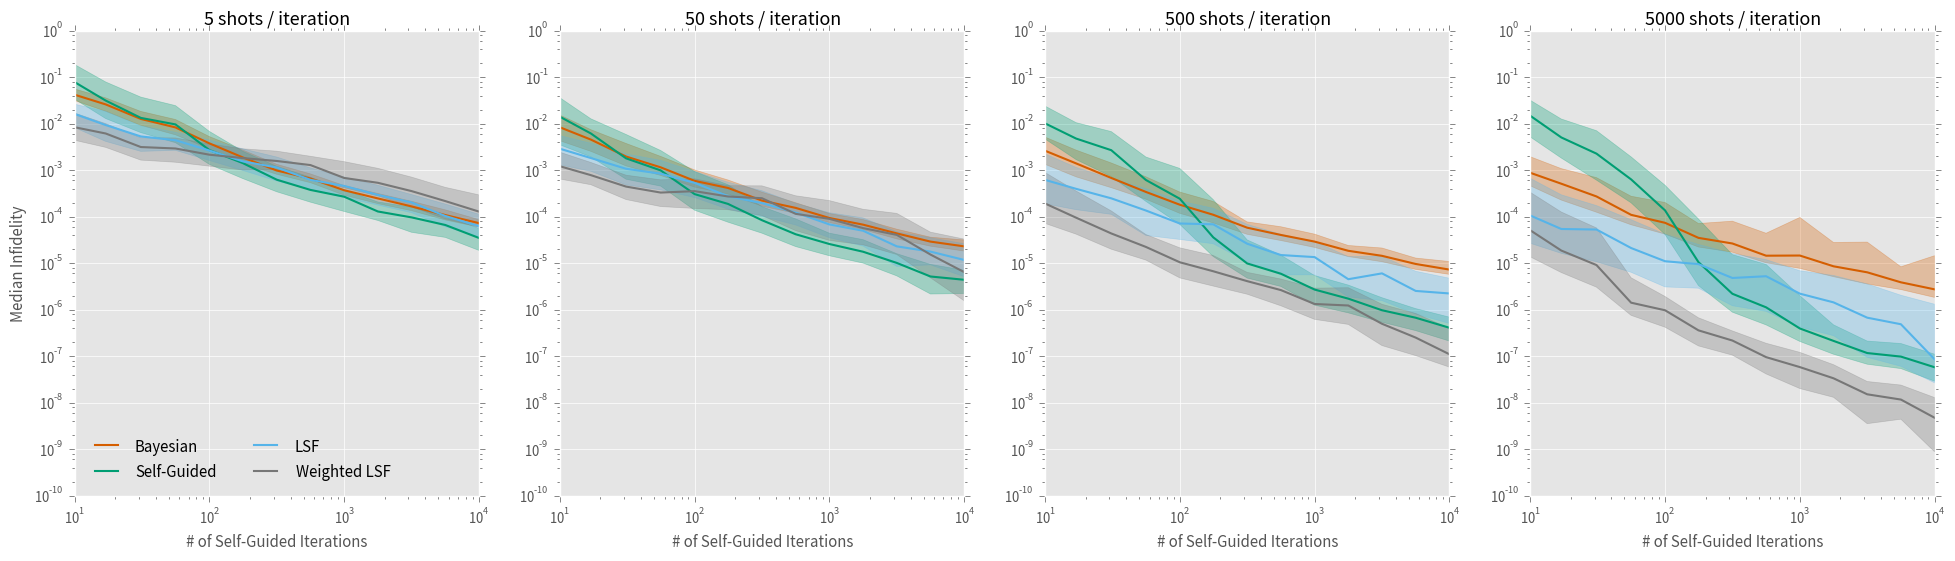

In [8]:
plt.figure(figsize=(24, 6))
data.pipe(select,
    dim=2, n_subsystems=1, true_prior_rank=1, n_particles=4000
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 50, 500, 5000]
)

That Bayesian approaches appear to be sub-optimal in case is a consequence of the loss function used. The Bayesian mean estimator is optimal for the quadratic loss, and only approximately optimal for infidelity. To show this, we plot a kernel density estimate of the loss according to both the infidelity and quadratic in the case of 50 shots and 1000 iterations.

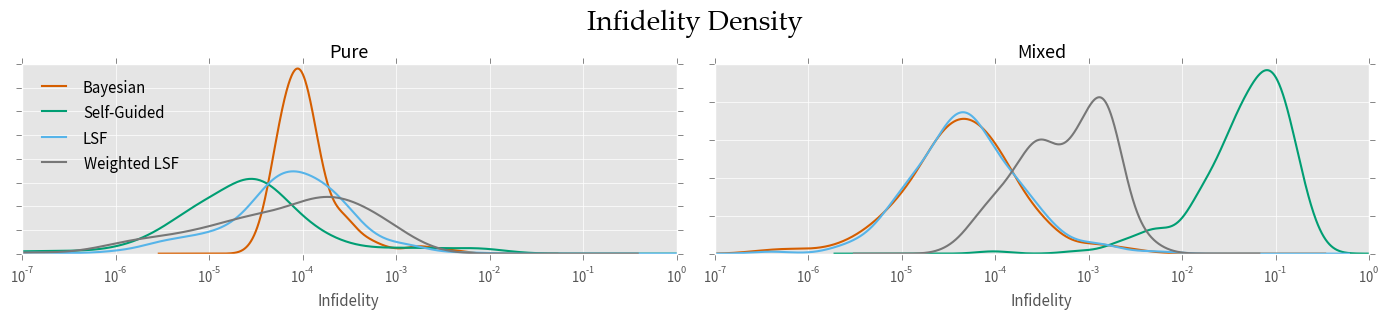

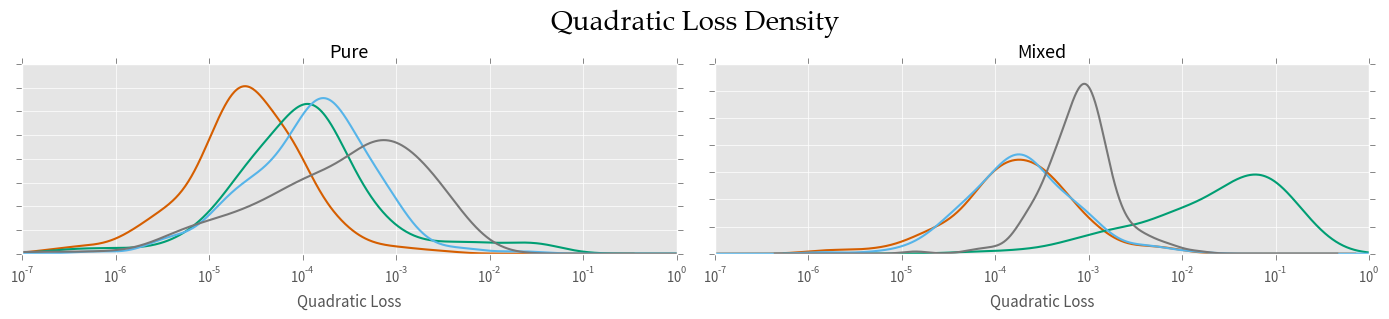

In [9]:
for idx_loss, loss in enumerate(['infidelity', 'quad_loss']):
    plt.figure(figsize=(14, 3.2))
    for rank in (1, 2):
        plt.subplot(1, 2, rank)
        for alg in ('smc', 'spsa', 'lsf', 'wlsf'):
            data.pipe(select,
                dim=2, n_subsystems=1, true_prior_rank=rank, n_particles=8000,
                n_shots=50, n_iters=1000
            )['{}_{}'.format(loss, alg)].apply(
                np.log10
            ).plot(
                kind='kde',
                label=ALG_NAMES[alg]
            )

        plt.xlim(-7, 0)
        plt.xlabel(['Infidelity', 'Quadratic Loss'][idx_loss])
        plt.ylabel('')
        plt.gca().yaxis.set_ticklabels([])
        plt.gca().get_xaxis().set_major_formatter(log_formatter(0))
        plt.title(['Pure', 'Mixed'][rank - 1])
        if rank == 1 and idx_loss == 0:
            plt.legend(ncol=1, loc='upper left')
    savefig('qubit-loss-density-{}'.format(loss), "{} Density".format(['Infidelity', 'Quadratic Loss'][idx_loss]))

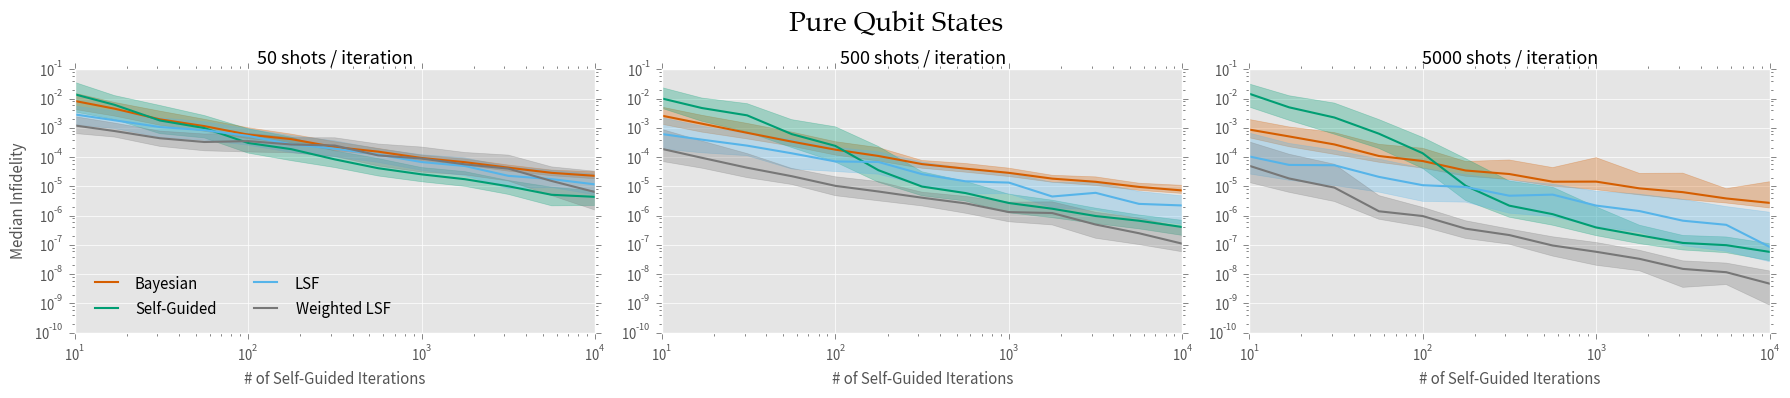

In [10]:
plt.figure(figsize=(18, 4))
data.pipe(select,
    dim=2, n_subsystems=1, true_prior_rank=1, n_particles=4000
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[50, 500, 5000]
)
savefig('pure-qubit-infid', 'Pure Qubit States')

### Mixed

For mixed states of a qubit, the story looks quite different in that self-guided approaches do not report an accurate estimate, while both least-squares and Bayesian estimators do well at postprocessing self-guided data.

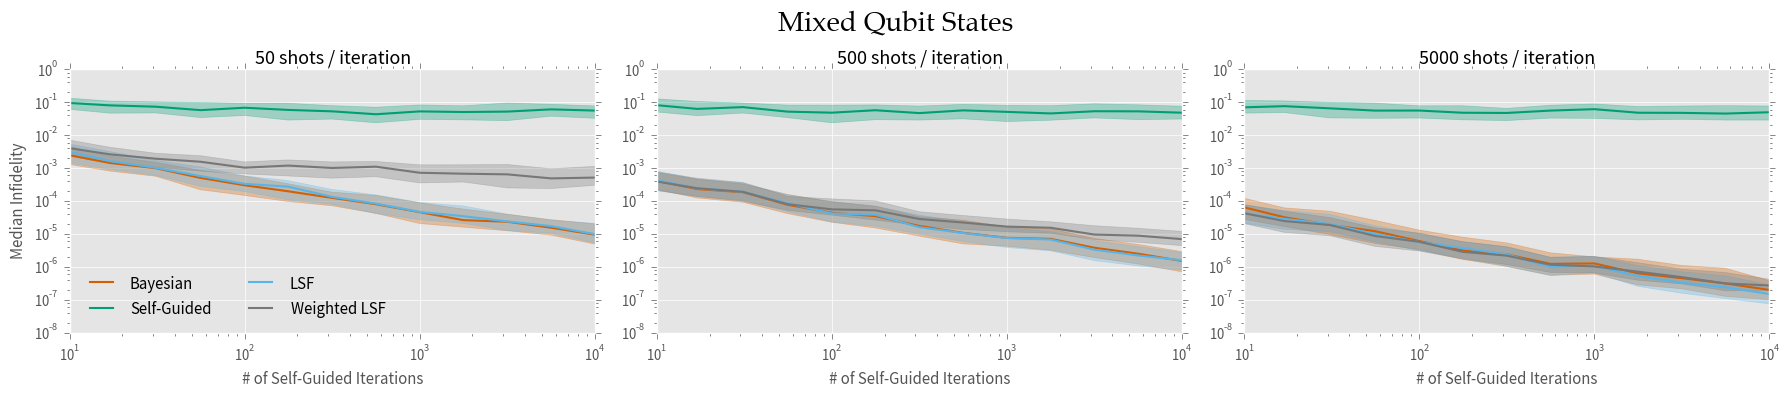

In [11]:
plt.figure(figsize=(18, 4))
data.pipe(select,
    dim=2, n_subsystems=1, true_prior_rank=2, n_particles=4000
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[50, 500, 5000]
)
savefig('mixed-qubit-infid', 'Mixed Qubit States')

This conclusion persists if we use the quadratic loss instead.

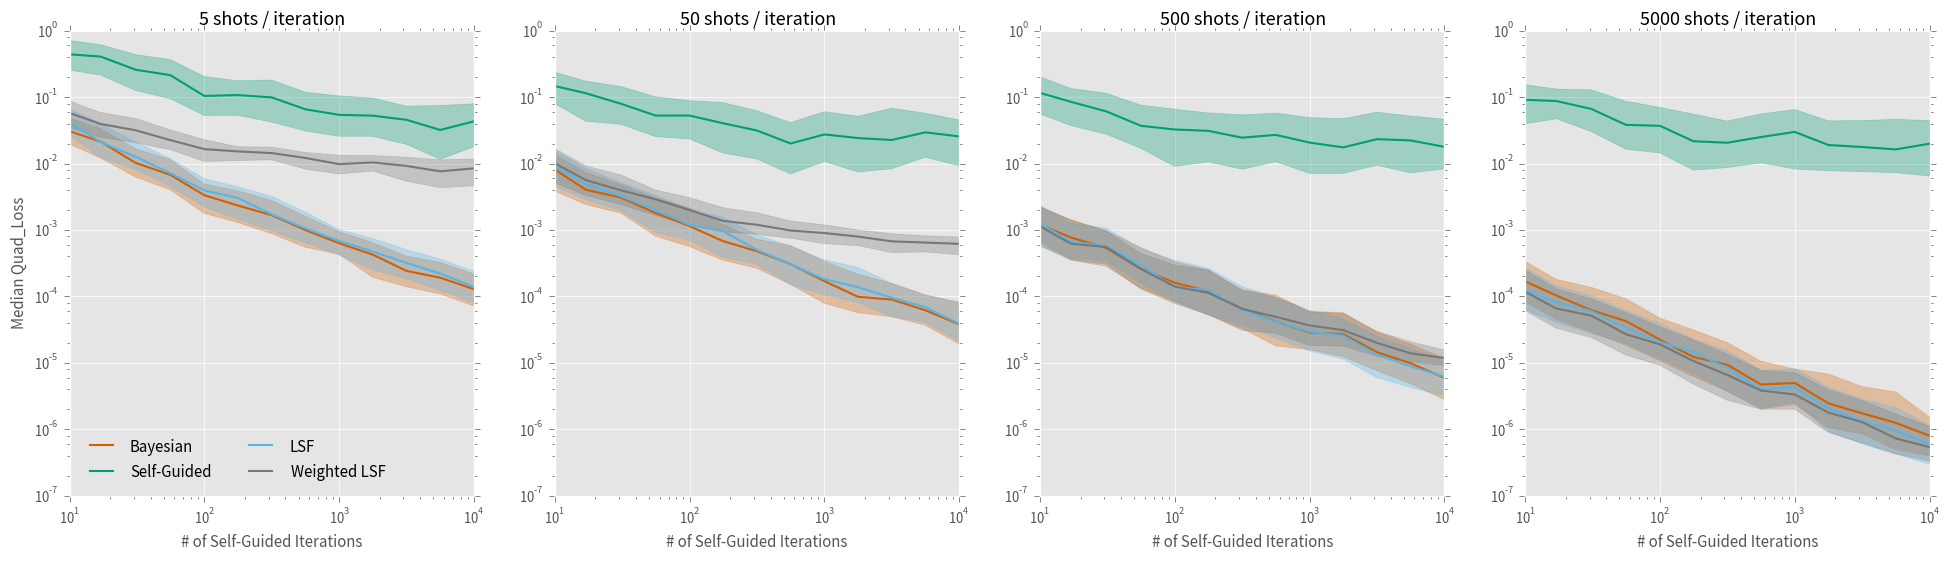

In [12]:
plt.figure(figsize=(24, 6))
data.pipe(select,
    dim=2, n_subsystems=1, true_prior_rank=2, n_particles=4000
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss',
    n_shotses=[5, 50, 500, 5000]
)

## Higher Dimensions ##

For pure qutrits, least squares fitting does somewhat worse with self-guided data, even according to the infidelity.

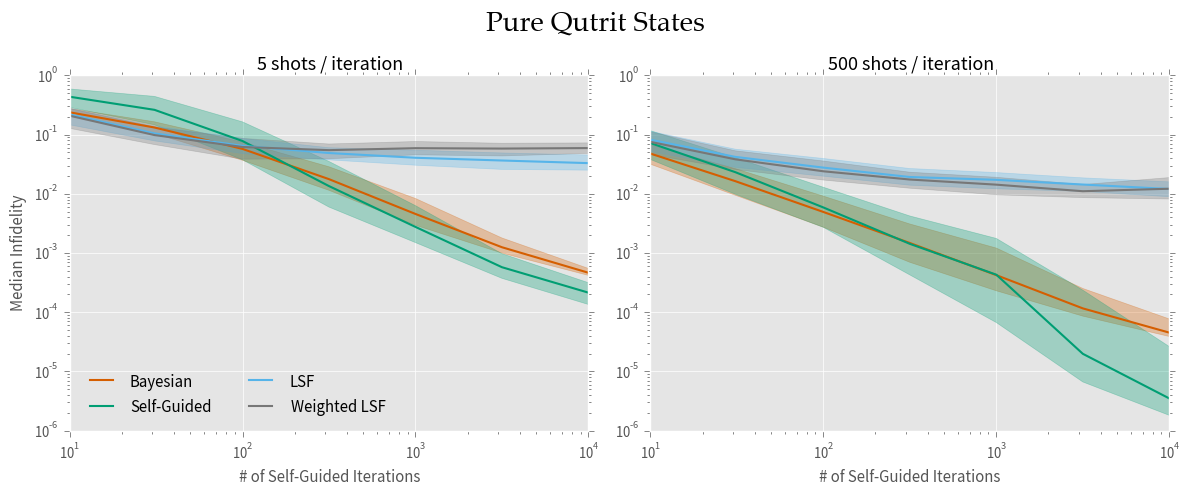

In [13]:
plt.figure(figsize=(12, 5))
data.pipe(select,
    dim=3, n_subsystems=1, true_prior_rank=1, n_particles=32000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 500]
)
savefig('pure-qutrit-infid', "Pure Qutrit States")

Measuring according to the quadratic loss, we observe that Bayesian approaches perform well, as expected.

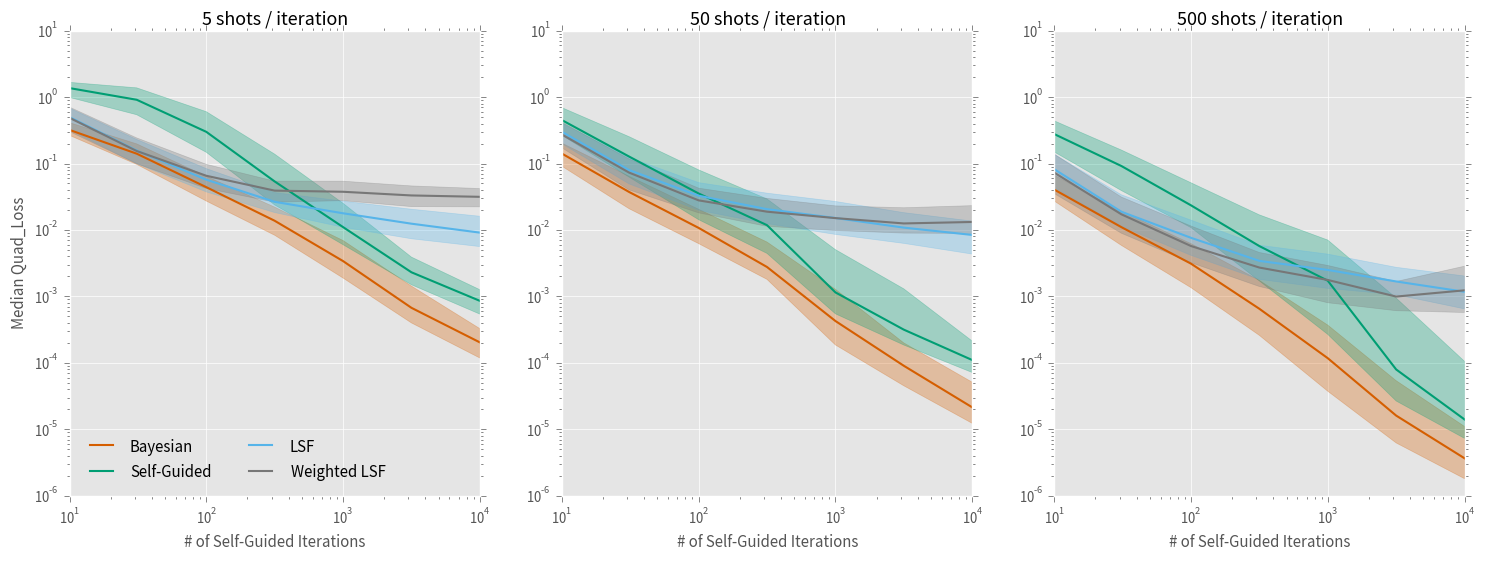

In [14]:
plt.figure(figsize=(18, 6))
data.pipe(select,
    dim=3, n_subsystems=1, true_prior_rank=1, n_particles=32000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss',
    n_shotses=[5, 50, 500]
)

For mixed states, however, both least-squares and Bayesian approaches work well for postprocessing self-guided data.

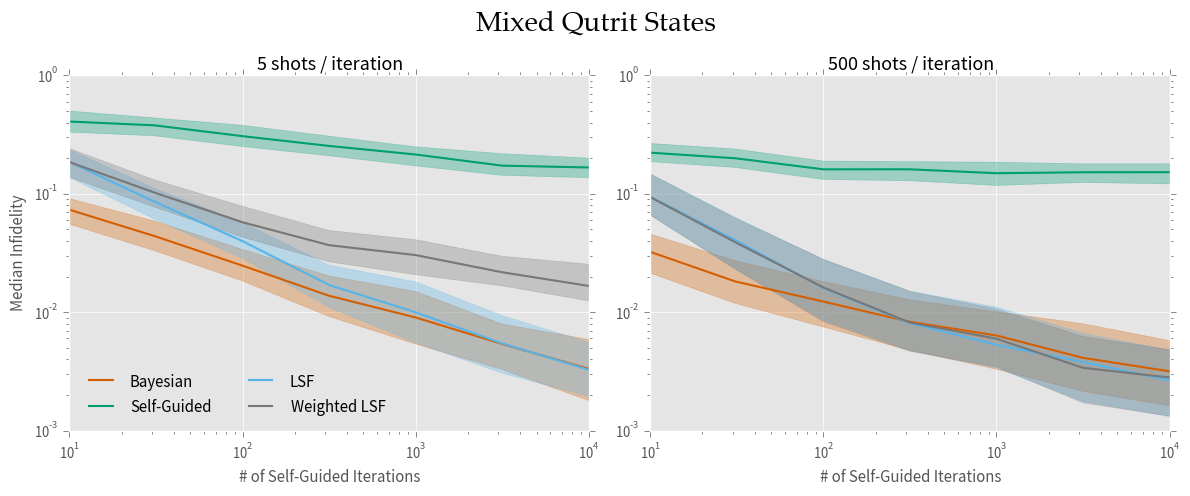

In [15]:
plt.figure(figsize=(12, 5))
data.pipe(select,
    dim=3, n_subsystems=1, true_prior_rank=3, n_particles=32000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 500]
)
savefig('mixed-qutrit-infid', "Mixed Qutrit States")

Next, we consider pure and mixed states of ququits ($d = 5$) and quseptets ($d = 7$).

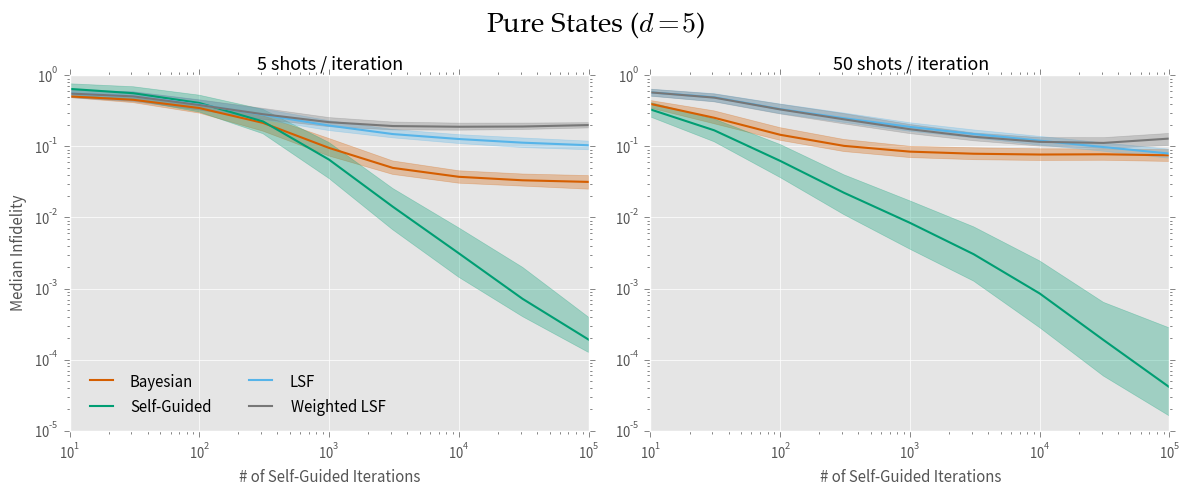

In [16]:
plt.figure(figsize=(12, 5))
data.pipe(select,
    dim=5, n_subsystems=1, true_prior_rank=1, n_particles=64000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 50]
)
savefig('pure-ququit-infid', "Pure States ($d = 5$)")

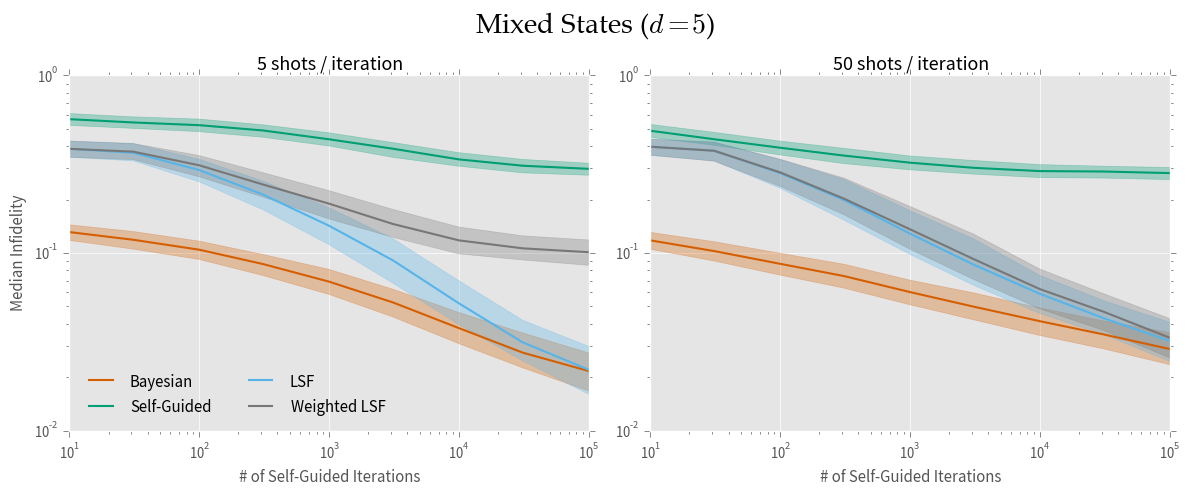

In [17]:
plt.figure(figsize=(12, 5))
data.pipe(select,
    dim=5, n_subsystems=1, true_prior_rank=5, n_particles=64000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 50]
)
savefig('mixed-ququit-infid', "Mixed States ($d = 5$)")

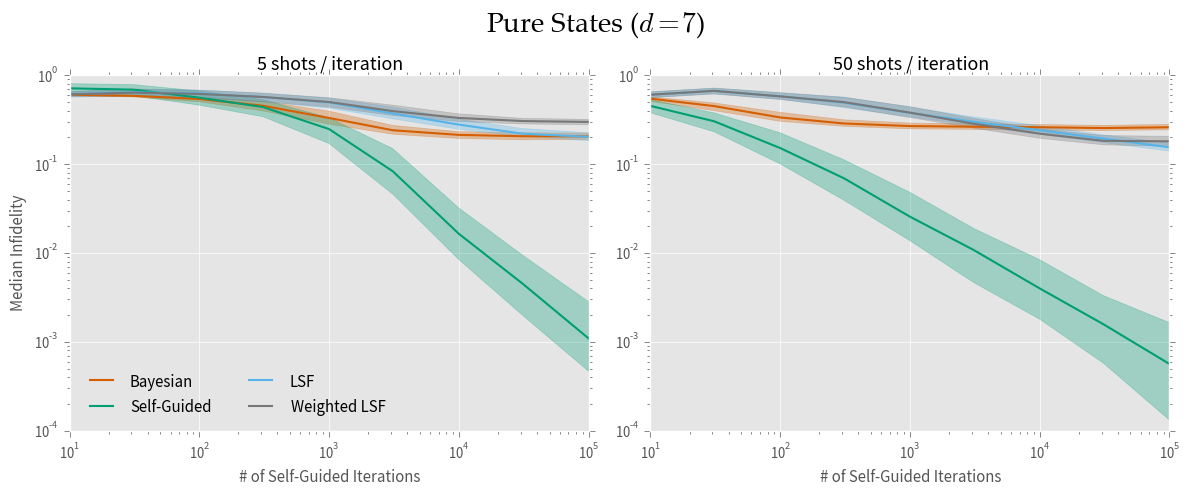

In [18]:
plt.figure(figsize=(12, 5))
data.pipe(select,
    dim=7, n_subsystems=1, true_prior_rank=1, n_particles=96000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 50]
)
savefig('pure-quseptet-infid', "Pure States ($d = 7$)")

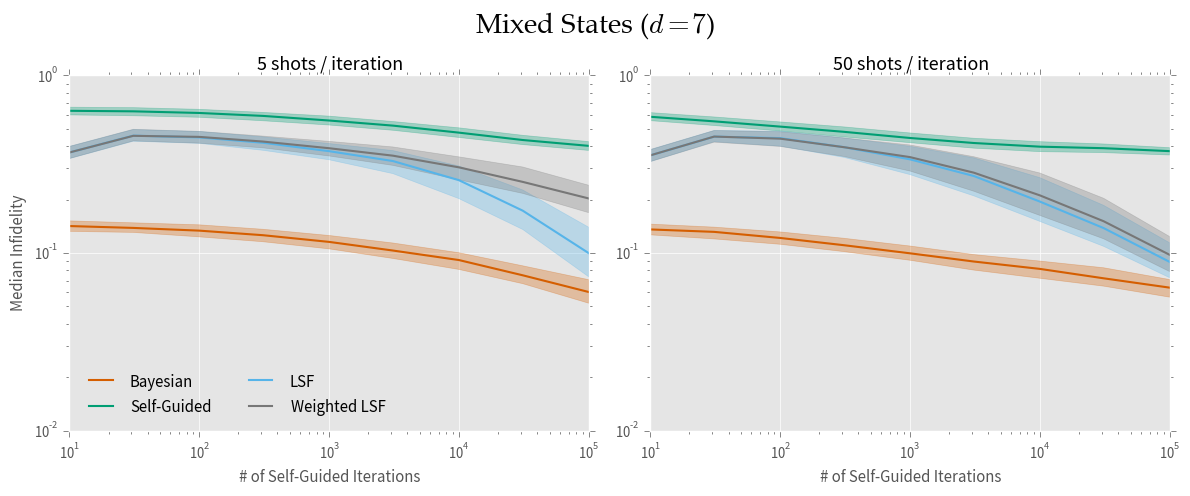

In [19]:
plt.figure(figsize=(12, 5))
data.pipe(select,
    dim=7, n_subsystems=1, true_prior_rank=7, n_particles=96000,
    resample_a=0.9
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 50]
)
savefig('mixed-quseptet-infid', "Mixed States ($d = 7$)")

## Exploring Self-Guided Parameters for 2 Qubits ##

In order to design self-guided experiments for product states, we need to explore a bit more to find good SPSA parameters. Here, we collect data self-guided data for a variety of different SPSA parameters.

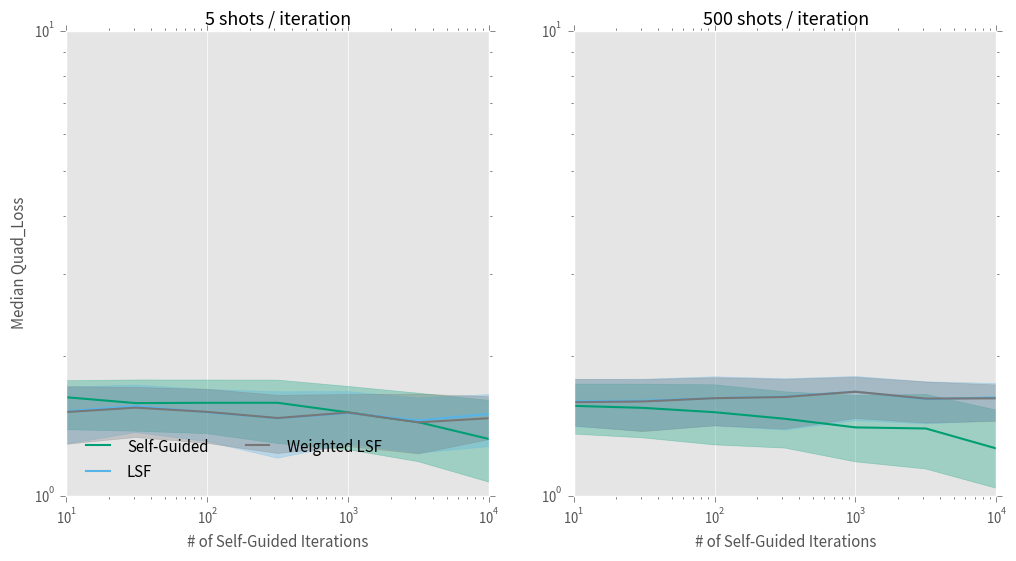

In [20]:
plt.figure(figsize=(12, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=1, step_scale=0.01      
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 500],
    incl_smc=False
)

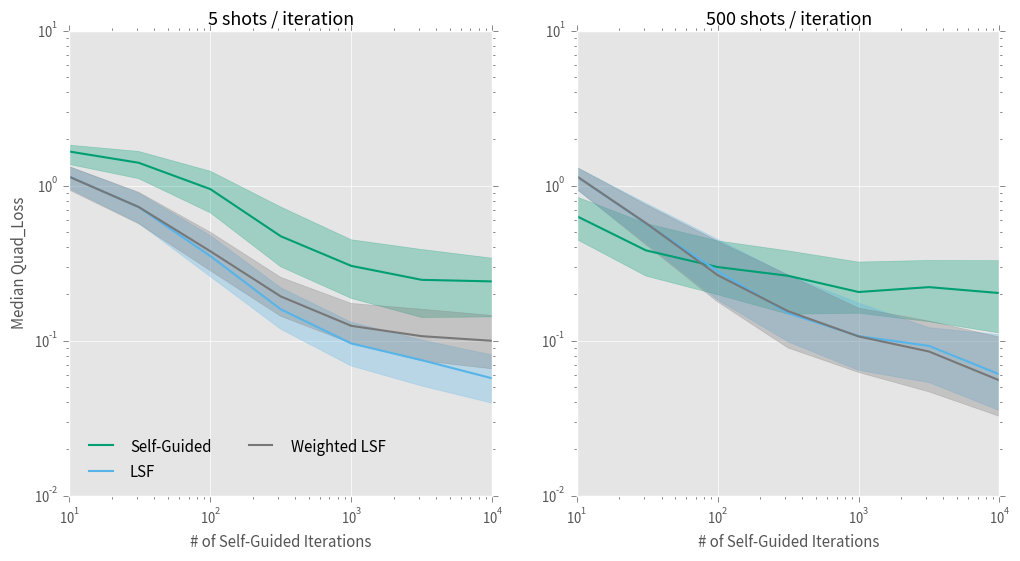

In [21]:
plt.figure(figsize=(12, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=10, step_scale=0.1      
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 500],
    incl_smc=False
)

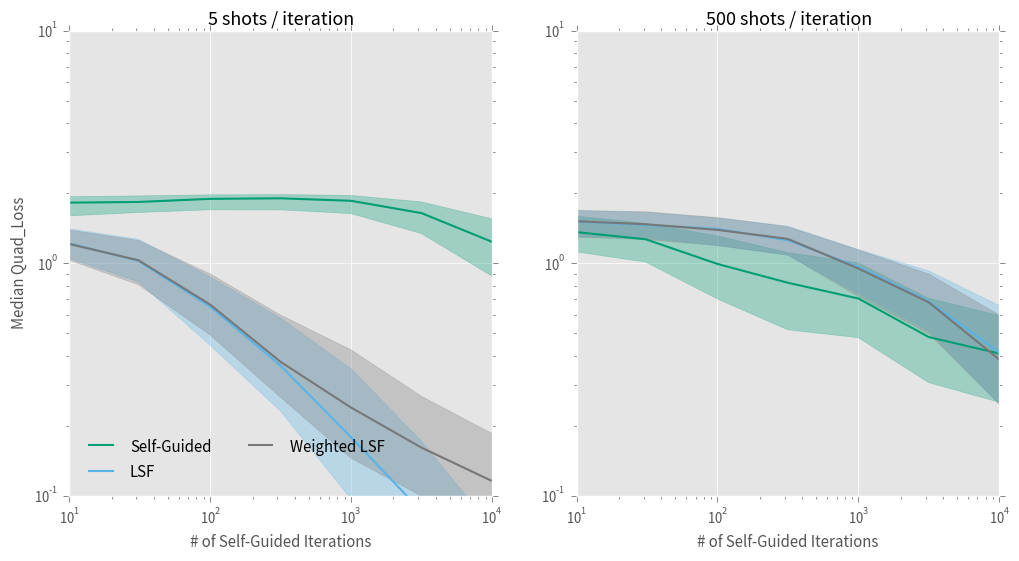

In [22]:
plt.figure(figsize=(12, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=10, step_scale=0.01      
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 500],
    incl_smc=False
)

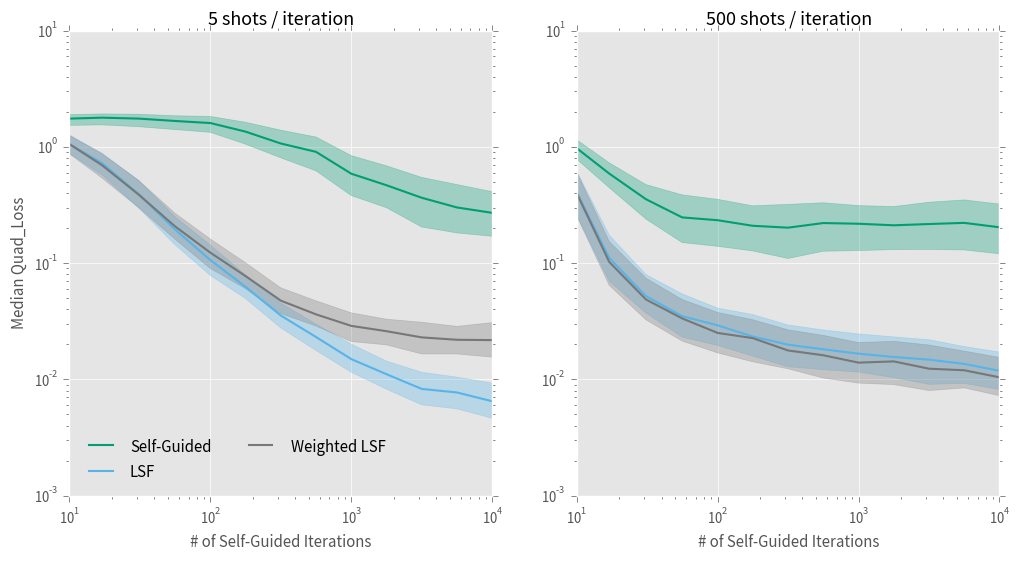

In [23]:
plt.figure(figsize=(12, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1      
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 500],
    incl_smc=False
)

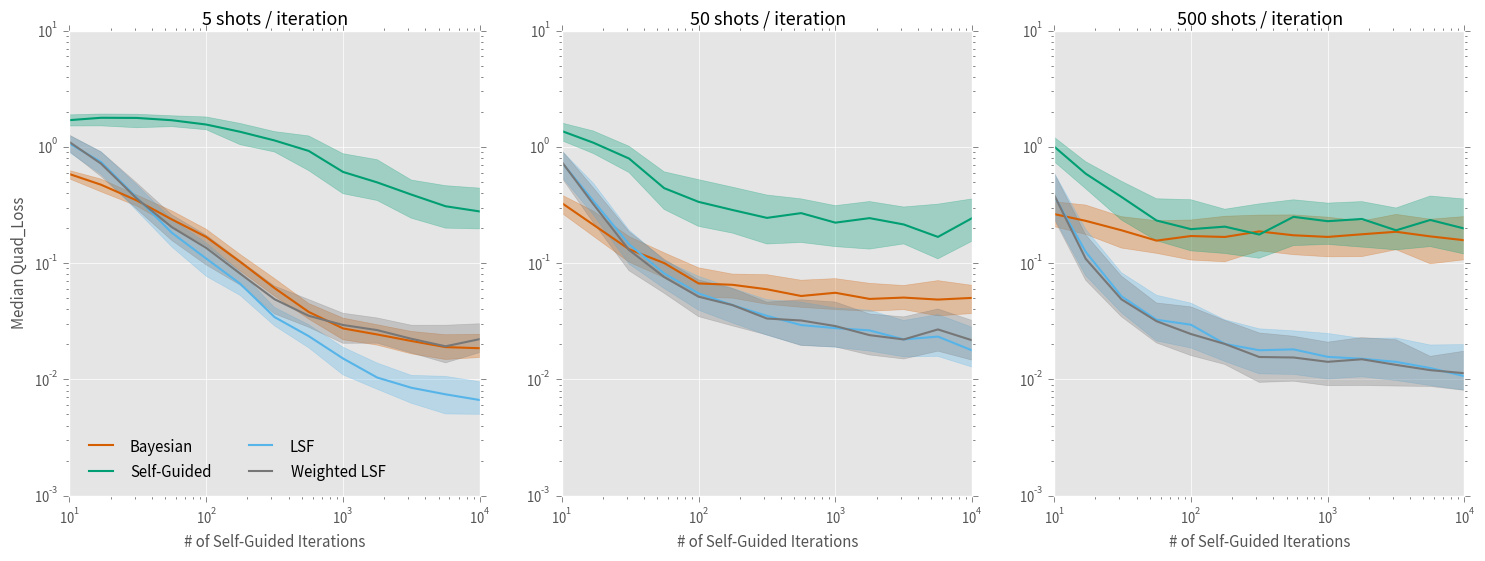

In [24]:
plt.figure(figsize=(18, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=16000
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 50, 500],
    incl_smc=True
)

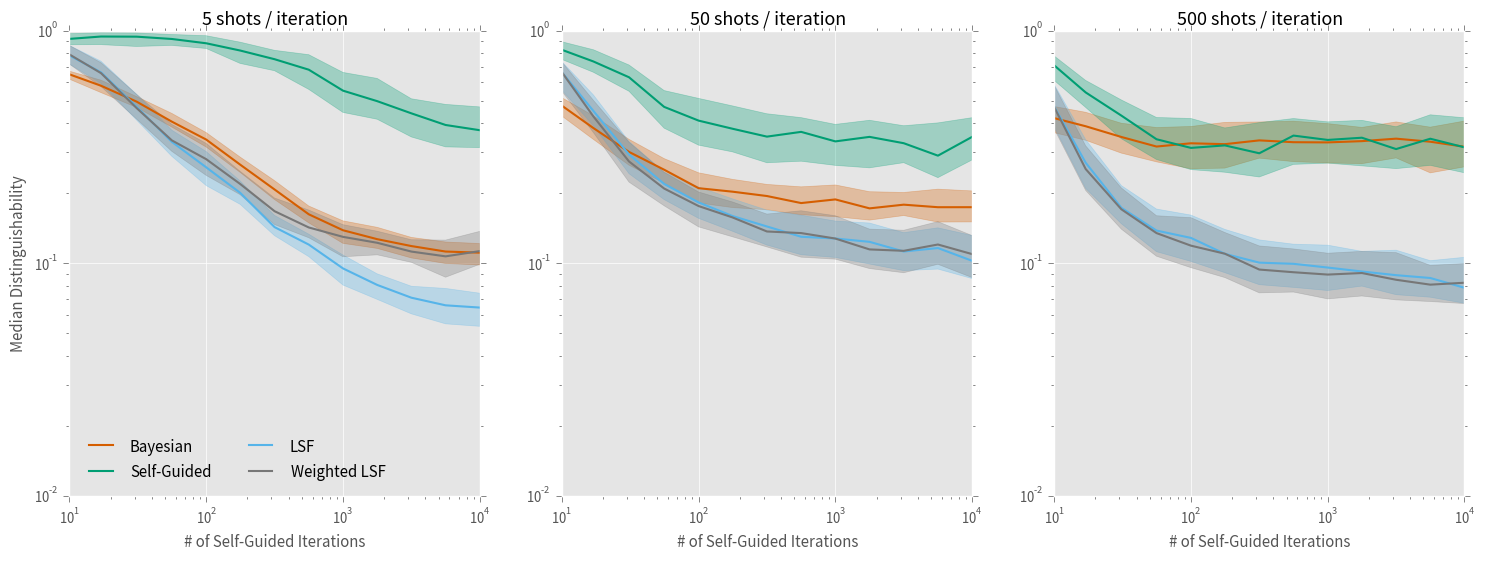

In [25]:
plt.figure(figsize=(18, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=16000
).pipe(plot_vs_iters_and_shots,
    loss_fn='distinguishability', n_shotses=[5, 50, 500],
    incl_smc=True
)

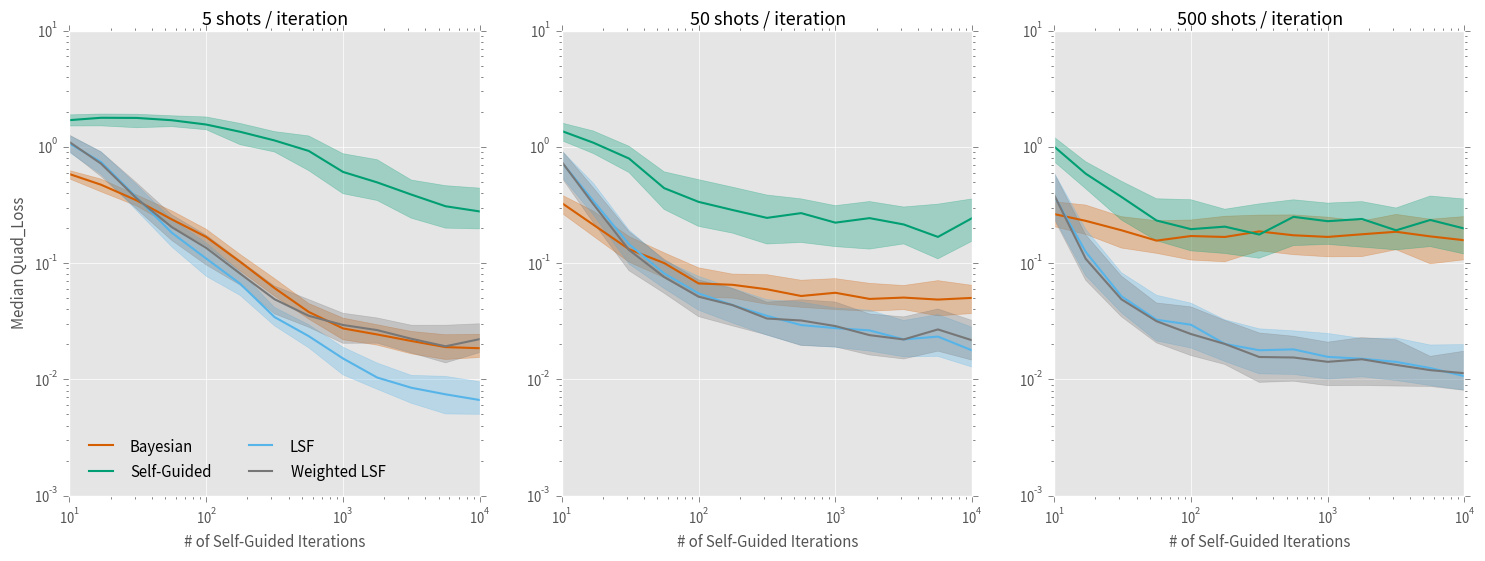

In [26]:
plt.figure(figsize=(18, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=16000
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 50, 500],
    incl_smc=True
)

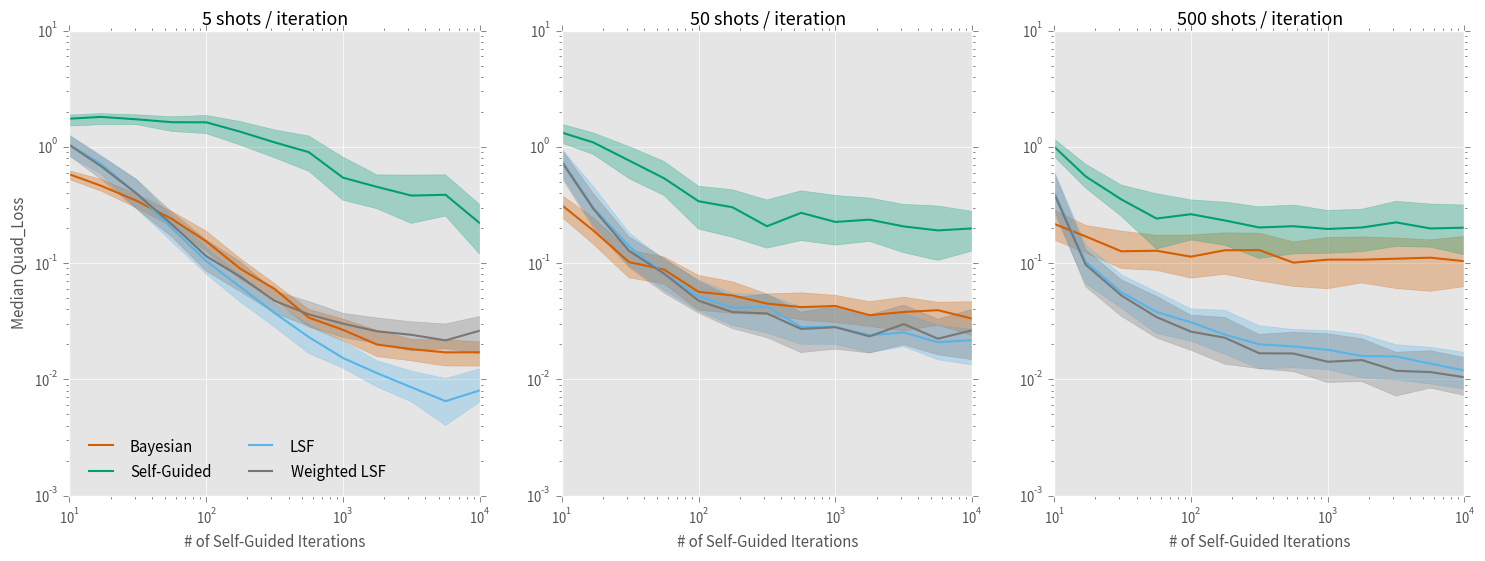

In [27]:
plt.figure(figsize=(18, 6))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=32000
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss', n_shotses=[5, 50, 500],
    incl_smc=True
)

We can now apply the parameters ``gain_scale=31`` and ``step_scale=0.1`` to pure and mixed product-state measurements.

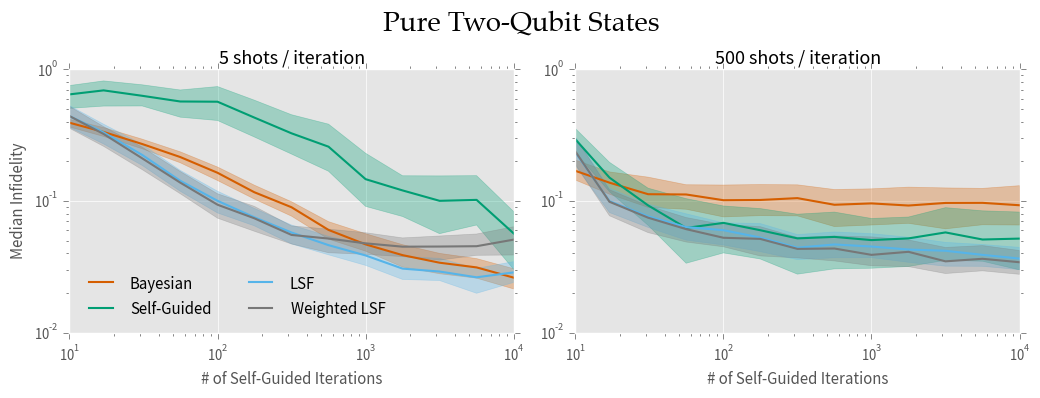

In [28]:
plt.figure(figsize=(10.5, 4))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=32000
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 500]
)
savefig('pure-two-qubit-infid', "Pure Two-Qubit States")

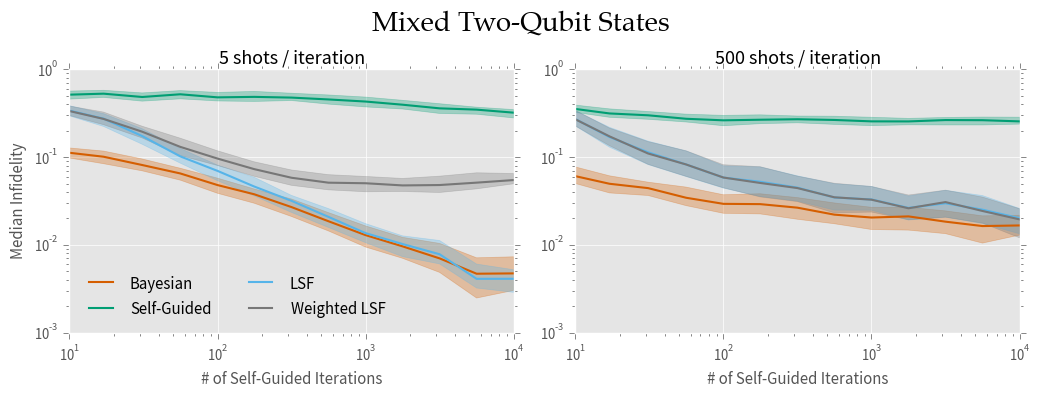

In [29]:
plt.figure(figsize=(10.5, 4))
data.pipe(select,
    true_prior_rank=4, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=32000
).pipe(plot_vs_iters_and_shots,
    loss_fn='infidelity',
    n_shotses=[5, 500]
)
plt.ylim(ymin=1e-3)
savefig('mixed-two-qubit-infid', "Mixed Two-Qubit States")

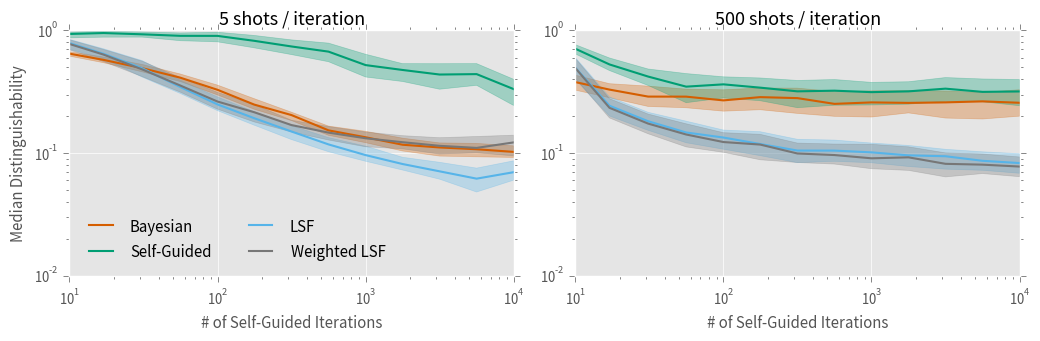

In [30]:
plt.figure(figsize=(10.5, 3.5))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=32000
).pipe(plot_vs_iters_and_shots,
    loss_fn='distinguishability',
    n_shotses=[5, 500]
)
savefig('pure-two-qubit-disting')

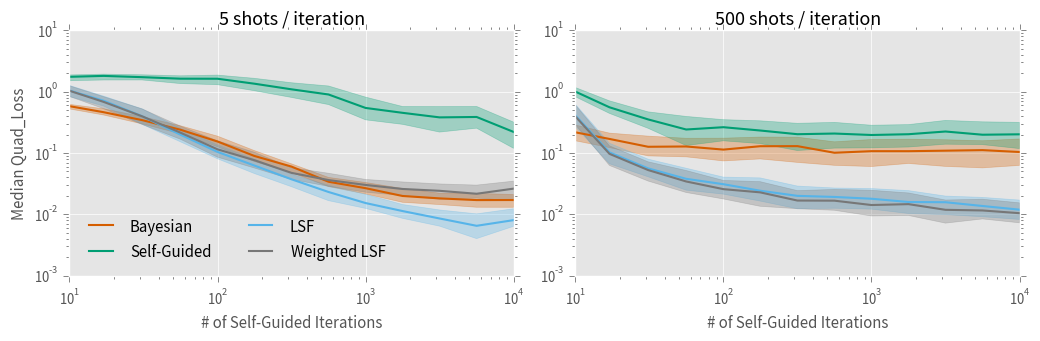

In [31]:
plt.figure(figsize=(10.5, 3.5))
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=32000
).pipe(plot_vs_iters_and_shots,
    loss_fn='quad_loss',
    n_shotses=[5, 500]
)
savefig('pure-two-qubit-quad')

## Condition Number Scaling ##

We also consider the scaling of the condition number of the LSF regression matrices with the number of iterations used. As discussed in the main text, the condition number should eventually scale as $\sqrt{n_{\text{iters}}}$.

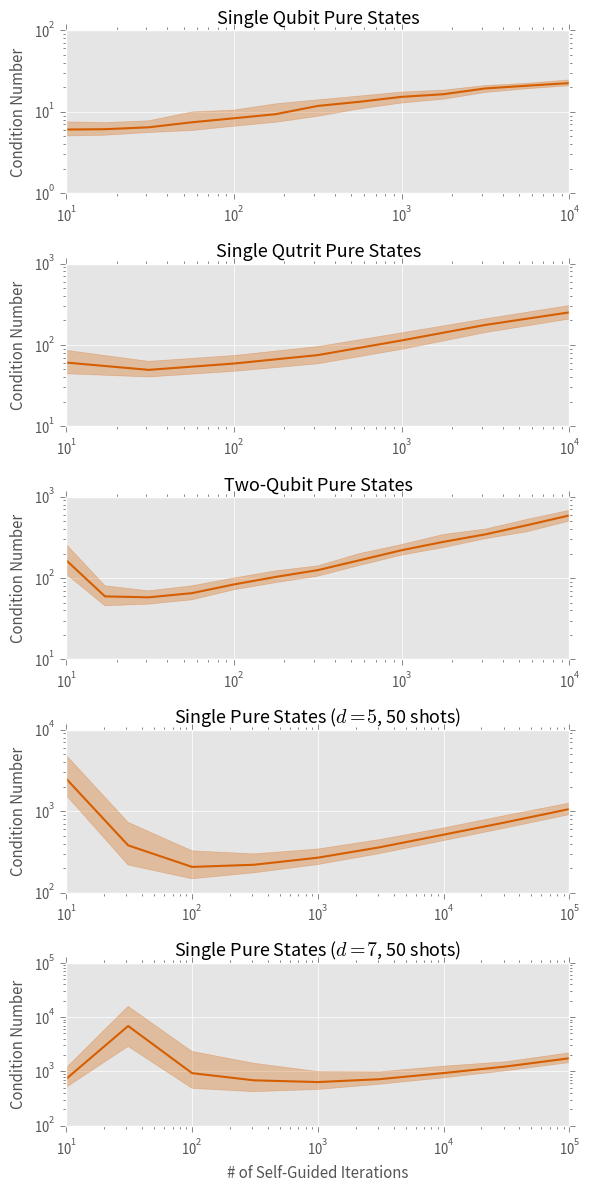

In [32]:
plt.figure(figsize=(6, 12))
plt.subplot(5, 1, 1)
ax = data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.98, n_subsystems=1,
    n_particles=8000, n_shots=500
).pipe(plot_quantile_errorfill,
    x_col='n_iters', y_col='cond_number',
    lower=0.32, upper=0.68
)
plt.ylabel('Condition Number')
plt.title('Single Qubit Pure States')

plt.yscale('log')
plt.xscale('log')


plt.subplot(5, 1, 2, sharex=ax)
data.pipe(select,
    true_prior_rank=1, dim=3, resample_a=0.9, n_subsystems=1,
    n_particles=32000, n_shots=500
).pipe(plot_quantile_errorfill,
    x_col='n_iters', y_col='cond_number',
    lower=0.32, upper=0.68
)
plt.ylabel('Condition Number')
plt.title('Single Qutrit Pure States')

plt.yscale('log')
plt.xscale('log')


plt.subplot(5, 1, 3, sharex=ax)
data.pipe(select,
    true_prior_rank=1, dim=2, resample_a=0.9, n_subsystems=2, gain_scale=31, step_scale=0.1,
    n_particles=32000, n_shots=500
).pipe(plot_quantile_errorfill,
    x_col='n_iters', y_col='cond_number',
    lower=0.32, upper=0.68
)
plt.ylabel('Condition Number')
plt.title('Two-Qubit Pure States')

plt.yscale('log')
plt.xscale('log')


plt.subplot(5, 1, 4, sharex=ax)
data.pipe(select,
    true_prior_rank=1, dim=5, resample_a=0.9, n_subsystems=1,
    n_particles=64000, n_shots=50
).pipe(plot_quantile_errorfill,
    x_col='n_iters', y_col='cond_number',
    lower=0.32, upper=0.68
)
plt.ylabel('Condition Number')
plt.title('Single Pure States ($d = 5$, 50 shots)')

plt.yscale('log')
plt.xscale('log')

plt.subplot(5, 1, 5, sharex=ax)
data.pipe(select,
    true_prior_rank=1, dim=7, resample_a=0.9, n_subsystems=1,
    n_particles=96000, n_shots=50
).pipe(plot_quantile_errorfill,
    x_col='n_iters', y_col='cond_number',
    lower=0.32, upper=0.68
)
plt.ylabel('Condition Number')
plt.title('Single Pure States ($d = 7$, 50 shots)')
plt.xlabel('# of Self-Guided Iterations')

plt.yscale('log')
plt.xscale('log')

savefig('cond-numbers')

## Postselection on Effective Sample Sizes ##

Finally, the *effective sample size* $n_{\text{ess}}$ of the sequential Monte Carlo (SMC) approximation, defined as
$$
    n_{\text{ess}} \mathrel{:=} 1 / \sum_i w_i^2,
$$
where $w_i$ are the weights of each SMC particle. As $n_{\text{ess}} \to 0$, the SMC approximation becomes numerically unstable. Though this is normally mitigated by resampling, approximation failures and surprising data can cause very small $n_{\text{ess}}$ to be observed between resampling steps. This condition can be used to flag a particular Bayesian estimator as being suspect. Thus, postselection on estimation runs with large effective sample sizes can significantly improve the mean performance of the Bayesian mean estimator approximated by SMC.

Here we show this by plotting the loss over qutrit and two-qubit hybrid state tomography experiments under a variety of conditions and showing that in a range of different conditions, postselecting on the minimal effective sample size being above some threshold can bring the mean performance closer to the median performance.

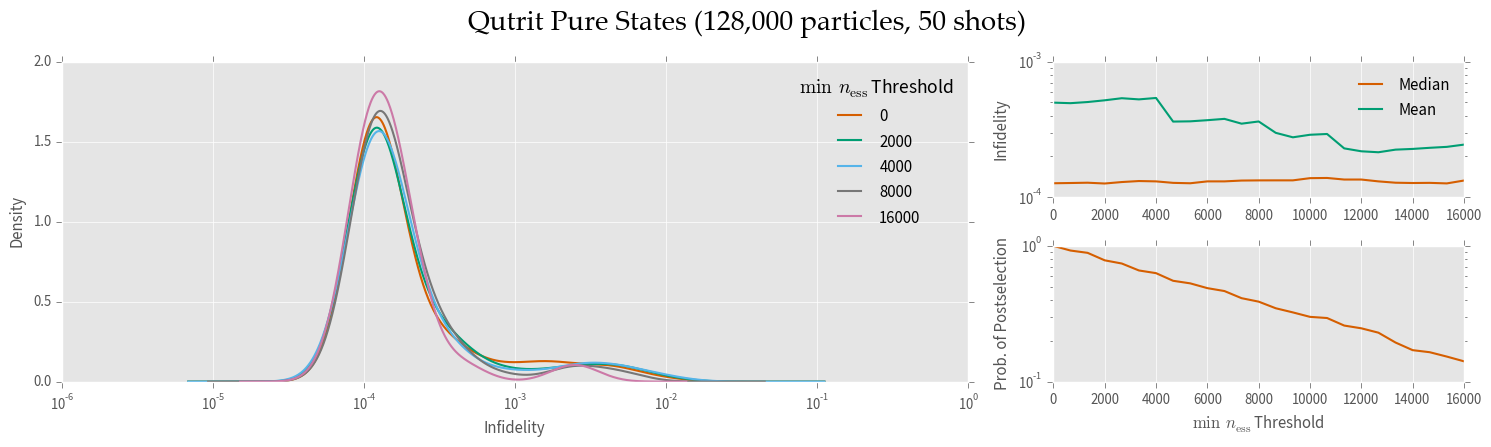

In [33]:
plt.figure(figsize=(15, 4.5))
data.pipe(select,
    n_particles=128000, dim=3, shuffle=False, true_prior_rank=1,
    n_subsystems=1,
    n_shots=50, n_iters=10000,
    resample_a=0.9
).pipe(plot_postsel,
    thresholds=np.linspace(0, 16000, 25).astype(int),
    plot_thresholds=[0, 2000, 4000, 8000, 16000]
)
savefig('qutrit-pure-postsel-128k-50s', "Qutrit Pure States (128,000 particles, 50 shots)")

In the case of highly informative data, however, this benefit is less pronounced.

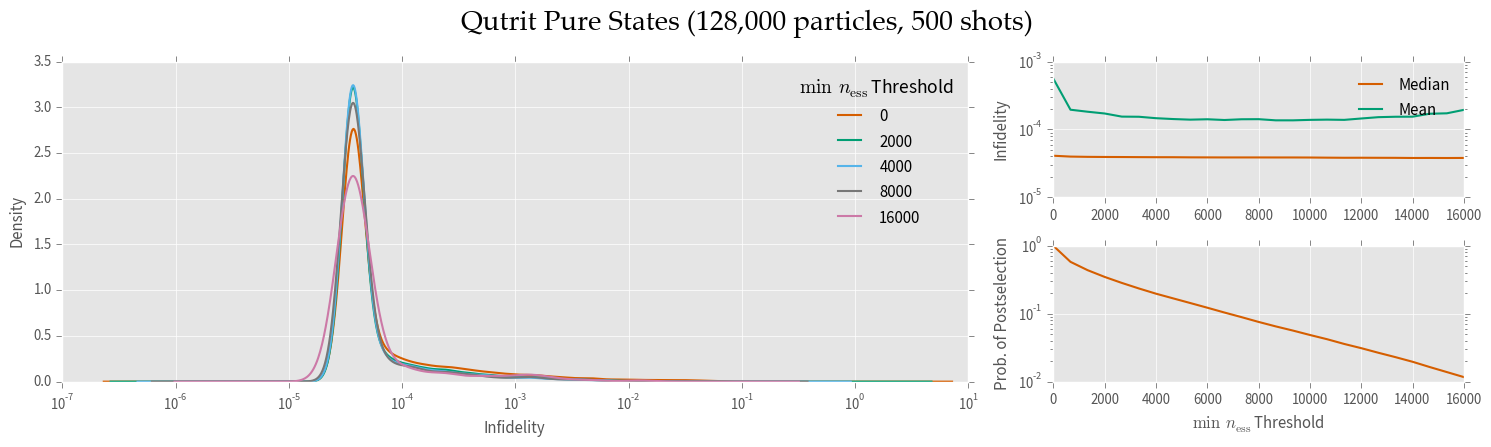

In [34]:
plt.figure(figsize=(15, 4.5))
data.pipe(select,
    n_particles=128000, dim=3, shuffle=False, true_prior_rank=1,
    n_subsystems=1,
    n_shots=500, n_iters=10000,
    resample_a=0.9
).pipe(plot_postsel,
    thresholds=np.linspace(0, 16000, 25).astype(int),
    plot_thresholds=[0, 2000, 4000, 8000, 16000]
)
savefig('qutrit-pure-postsel-128k-500s', "Qutrit Pure States (128,000 particles, 500 shots)")

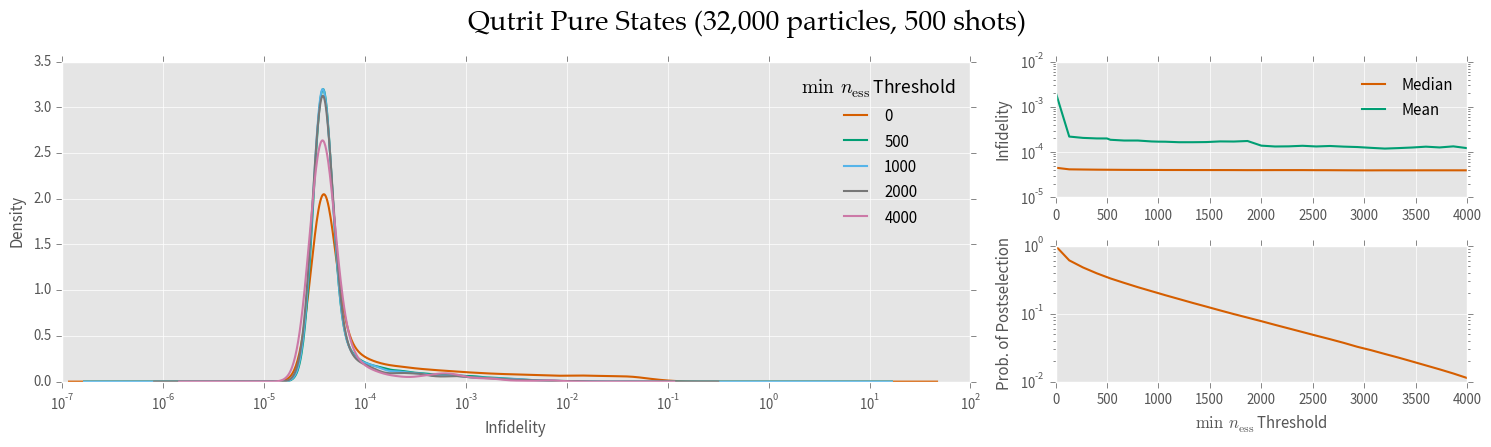

In [35]:
plt.figure(figsize=(15, 4.5))
data.pipe(select,
    n_particles=32000, dim=3, shuffle=False, true_prior_rank=1,
    n_subsystems=1,
    n_shots=500, n_iters=10000,
    resample_a=0.9
).pipe(plot_postsel,
    thresholds=np.linspace(0, 4000, 31).astype(int),
    plot_thresholds=[0, 500, 1000, 2000, 4000]
)
savefig('qutrit-pure-postsel-32k-500s', "Qutrit Pure States (32,000 particles, 500 shots)")

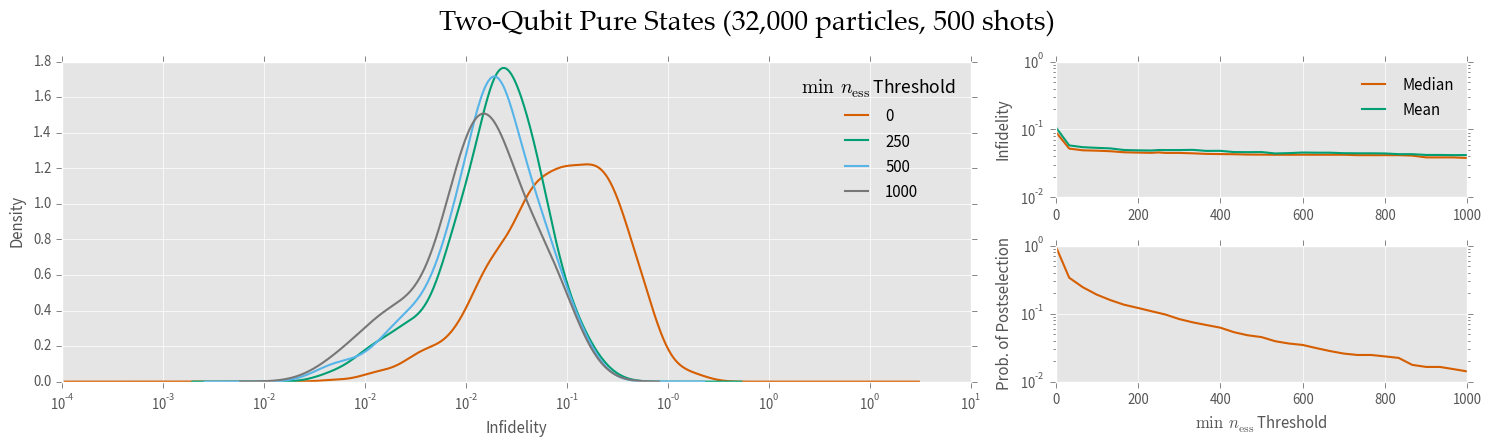

In [36]:
plt.figure(figsize=(15, 4.5))
data.pipe(select,
    n_particles=32000, dim=2, shuffle=False, true_prior_rank=1,
    n_subsystems=2,
    n_shots=500, n_iters=10000
).pipe(plot_postsel,
    thresholds=np.linspace(0, 1000, 31).astype(int),
    plot_thresholds=[0, 250, 500, 1000]
)
savefig('two-qubit-pure-postsel', "Two-Qubit Pure States (32,000 particles, 500 shots)")